In [27]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
import tensorflow as tf
import pandas as pd
from utils import *
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Embedding, RNN, LSTM, Bidirectional
from tensorflow import keras
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


found yoochoose cache


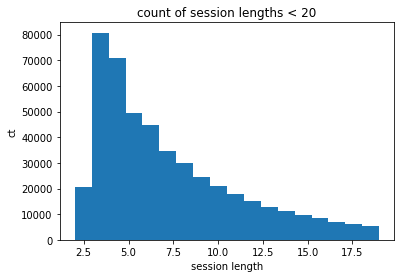

max_embedding_key: 52738
max_session_len: 262
509696 examples
split into 326205 train, 81551 val, 101940 test
[[3647, 3647], [2329, 2329, 1047, 2329], [56, 56, 56], [250, 250, 6884], [136, 36427, 36428, 36420, 7608, 7608, 288, 535], [46353, 46353, 12899, 11676], [46967, 46932, 46944, 45814, 22101, 12139, 46937, 47482, 47531, 46944, 47482, 47531], [4788, 248, 248, 248], [121, 43182, 121, 43182, 43182, 43182], [802, 28344, 802, 28344], [45316, 201, 419, 45299, 201], [4514, 1137, 818, 3513, 3319, 3513, 3513, 3513], [5765, 49304, 49304, 3447, 49304, 49304], [30744, 30740, 30740], [9760, 8779, 8779, 5862, 9760, 5862, 5862, 8779], [37900, 37870, 37900, 37882, 36718, 37870, 37900], [44606, 44618, 44606, 44618], [32209, 32209, 39239, 1075, 1075, 30930, 39287, 39296, 3034, 30930, 39296, 32209, 1075, 3034], [45224, 916, 63, 45224, 916, 63], [4956, 1192, 1189, 4956, 6884, 1189, 1189, 1189], [296, 2924, 296, 296, 296, 296], [3734, 492, 3734, 3735, 3734, 3734, 3735, 3735, 3734, 3735, 7410, 6795], [

In [33]:
dataset, column_names, keymap = load_yoochoose_dataset(reinitialize=False)
num_sessions = len(dataset)

plt.hist([len(session) for session in dataset if len(session) < 20], bins=18)
plt.xlabel("session length")
plt.ylabel("ct")
plt.title("count of session lengths < 20")
plt.show()

max_embedding_key = len(keymap)-1
max_session_len = max([len(i) for i in dataset])
print(f"max_embedding_key: {max_embedding_key}")
print(f"max_session_len: {max_session_len}")

dataset = [[item[0] for item in session] for session in dataset]

(x_train,), (x_val,), (x_test,) = train_val_test_split(dataset)

print(f"{len(dataset)} examples")
print(f"split into {len(x_train)} train, {len(x_val)} val, {len(x_test)} test")

# x_train = np.array(list(train))
# x_val = np.array(list(val))
# x_test = np.array(list(test))

print(x_train[:50])

In [6]:
# for x, y in zip(x_train_p[:50], y_train_p[:50]):
#     print(x, y)

[ 1515  1515  1515  1515 30735 30759 30734 30734] 1.0
[21268  3214 25408 46409 44769 50098 49776 46816] 0.0
[48265 48259 32209 45767 44083 48285 48576  7705] 1.0
[ 7533 17925 21681 30089 46796 18417 51930 33875] 0.0
[ 547 8933  547  547    0    0    0    0] 1.0
[1012 1012 1012 1012    0    0    0    0] 1.0
[46296 46299 46320 46296 46299 46320     0     0] 1.0
[503 743 743 743 743 503 743 743] 1.0
[46295 23163 46295 23163     0     0     0     0] 1.0
[30744 30744 30740 28446 28446 30744 30744   208] 1.0
[ 2076    10  2076  2076  8832 33704  1052 33704] 1.0
[42846  5552 36035 37878 29016 45778 48261 43155] 1.0
[47405 40276 39049 52382 25740 23269  6268 38591] 0.0
[47513 47513 47513     0     0     0     0     0] 1.0
[43160 43160     0     0     0     0     0     0] 1.0
[48620 45448 17401 30758 36343 15931 31024 28131] 0.0
[33864 23967 20195 47002 11923 32697 18570 45178] 0.0
[44615 44599 44615 44599     0     0     0     0] 1.0
[37836 38311 52704 35447 24440 21987 26329 17472] 0.0
[25308

In [19]:
class IdkModel(Model):
    def __init__(self):
        super(IdkModel, self).__init__()
        self.embedding_layer = Embedding(max_embedding_key, 128, input_length=max_session_len)
        self.encoder = Bidirectional(LSTM(64, return_sequences=False, return_state=False, unroll=False), merge_mode="concat")
        self.final_dense_layer = Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')
        self.sigmoid_layer = Dense(max_embedding_key, kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='softmax')

    # def build_item_attention(self):
    #     self.item_attention_W = 

    def call(self, x):
        encoder_output = self.encoder(self.embedding_layer(x))
        return self.sigmoid_layer(self.final_dense_layer(encoder_output))

In [ ]:
"""
model notes:
attention: given a variable length vector A of fixed length vectors, construct a fixed length vector where each element is the output of a tanh * sigmoid. the sigmoid is a gate on the tanh that determines how important that vector is A. Importance is calculated from sigmoid of the dot product between the vector with the trainable importance vector
            thus, attention is fundamentally a fully connected layer gated with sigmoid based on how similar the input is at that vector to the trainable importance vector.
            attention masking: 
                there is still the problem that the output of attention has to be a fixed length vector. 
                to do this, the goal is to pad the attention vector with zeros
                to do this, pad the output of u_{it}^T u_w with -infs so that the output of the softmax would be 0 and that these values won't affect the final ah

"""

In [6]:
batch_size = 64

# model = IdkModel()

# model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_train_p, y_train_p, batch_size=64, epochs=4, validation_data=[x_val, y_val])


Train on 652410 samples, validate on 81551 samples
Epoch 1/4
652410/652410 [==============================] - 516s 791us/sample - loss: 0.0829 - accuracy: 0.9792 - val_loss: 0.0215 - val_accuracy: 0.9928
Epoch 2/4
652410/652410 [==============================] - 512s 784us/sample - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.0367 - val_accuracy: 0.9915
Epoch 3/4
652410/652410 [==============================] - 510s 782us/sample - loss: 7.7947e-04 - accuracy: 0.9998 - val_loss: 0.0488 - val_accuracy: 0.9932
Epoch 4/4
652410/652410 [==============================] - 514s 788us/sample - loss: 8.4637e-05 - accuracy: 1.0000 - val_loss: 0.0728 - val_accuracy: 0.9934


In [ ]:
# with tf.Session() as sess:
#     y_true = tf.placeholder(dtype=tf.float64, shape=[None, 1])

#     learning_rate=.001
#     epochs=60
#     ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
#     train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(ce_loss_term)

#     sess.run(tf.global_variables_initializer())

#     for epoch in tqdm(range(epochs), leave=False):
#         print("epoch", epoch)
#         print("training")
#         for b_Xs, b_ys in batchify(train_Xs, train_ys, batch_size=746661):
#             session_idxs, item_idxs = b_Xs.T
#             feed_dict = {session_slice_idxs: session_idxs, 
#                         item_slice_idxs: item_idxs, 
#                         y_true: b_ys}
#             outs = (train_step, ce_loss_term, pred_y)
#             _, loss_val, pred_y_val = sess.run(outs, feed_dict=feed_dict)
#             print("pred_ys", pred_y_val, "true_ys", b_ys[:5])



In [49]:
from tqdm import tqdm

batch_size = 128

# model.fit(x_train_p, y_train_p, batch_size=batch_size, epochs=4, validation_data=[x_val, y_val])

# row_id_to_idx = {k: v for v, k in enumerate(set(clicks_df["sessionId"])|set(buys_df["sessionId"]))}
# col_id_to_idx = {k: v for v, k in enumerate(set(clicks_df["itemId"])|set(buys_df["itemId"]))}

# matrix_shape = (len(row_id_to_idx), len(col_id_to_idx))

# row_indices = [row_id_to_idx[row_id] for row_id in clicks_df["sessionId"]]
# col_indices = [col_id_to_idx[col_id] for col_id in clicks_df["itemId"]]
# elements = np.ones(len(col_indices), dtype=np.int8)
# viewed_matrix = csr_matrix((elements, (row_indices, col_indices)), shape=matrix_shape)

# row_indices = [row_id_to_idx[row_id] for row_id in buys_df["sessionId"]]
# col_indices = [col_id_to_idx[col_id] for col_id in buys_df["itemId"]]
# elements = np.ones(len(col_indices), dtype=np.int8)
# buys_matrix = csr_matrix((elements, (row_indices, col_indices)), shape=matrix_shape)

# interaction_matrix = 2*buys_matrix-viewed_matrix
model = IdkModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


@tf.function
def train_step(sessions, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(sessions, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(sessions, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(sessions, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


EPOCHS = 5
num_x = len(x_train)

for epoch in range(EPOCHS):
    print(f"epoch {epoch}/{EPOCHS}")
# Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    assert(batch_size == int(batch_size/2)*2)
    for i, batch_sess in enumerate(batchify_bin_by_sess_len(x_train, batch_size=int(batch_size/2), split_long_sess=False)):
        batch_sess, batch_labels = augment_negative_examples(batch_sess, max_embedding_key)
        train_step(tf.constant(batch_sess), tf.constant(batch_labels))
        if i % 10 == 0:
            tf.print(f"batch {i}/~{num_x/(batch_size/2)}: {train_accuracy.result()} session length: {len(batch_sess[0])}")

    for i, batch_sess in enumerate(batchify_bin_by_sess_len(x_val, batch_size=int(batch_size/2), split_long_sess=False)):
        batch_sess, batch_labels = augment_negative_examples(batch_sess, max_embedding_key)
        test_step(tf.constant(batch_sess), tf.constant(batch_labels))

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
        train_loss.result(),
        train_accuracy.result()*100,
        test_loss.result(),
        test_accuracy.result()*100))


758464097976685 session length: 3
batch 116480.0/~326205: 0.9758288860321045 session length: 3
batch 117120.0/~326205: 0.9757347702980042 session length: 3
batch 117760.0/~326205: 0.9756968021392822 session length: 3
batch 118400.0/~326205: 0.9756888151168823 session length: 3
batch 119040.0/~326205: 0.9756767153739929 session length: 3
batch 119680.0/~326205: 0.975648045539856 session length: 3
batch 120320.0/~326205: 0.9756363034248352 session length: 3
batch 120960.0/~326205: 0.9755998849868774 session length: 3
batch 121600.0/~326205: 0.9755556583404541 session length: 3
batch 122240.0/~326205: 0.9755200147628784 session length: 3
batch 122880.0/~326205: 0.975525438785553 session length: 3
batch 123520.0/~326205: 0.9755187034606934 session length: 3
batch 124160.0/~326205: 0.9754999279975891 session length: 3
batch 124800.0/~326205: 0.9755173921585083 session length: 3
batch 125440.0/~326205: 0.9755067825317383 session length: 3
batch 126080.0/~326205: 0.975496232509613 session len

In [35]:
print(x_train[:10])

model.predict(np.array([[42449, 42446, 42436, 42335, 42461, 42449, 42436, 42335]], dtype=np.uint32))


# plt.hist(np.sum(interaction_matrix, axis=1), log=True, bins=300)
# plt.xlabel("item views per session")
# plt.ylabel("count")
# plt.show()

[[44123 44120 44094  5775 44123 44120 44094     0]
 [   49 23331 23331 28328 28328 28328     0     0]
 [42449 42446 42436 42335 42461 42449 42436 42335]
 [46988 46971 46971 46971     0     0     0     0]
 [32209 33029 30930 32209 32207 33028 33042 33051]
 [  682  3753   162   162 23216   162     0     0]
 [44590 44580 44580 40664 40664 44134 44134 45253]
 [ 1907  2424 34814  2327 34814  1907  2424 34814]
 [30865  8946 30865 30865     0     0     0     0]
 [  874   874   402   402   162   162   162   284]]


array([[5.89e-05, 1, 5.39e-18, 5.6e-18, 5.2e-18, 3.76e-18, 3.69e-18, 7.16e-18, 6.38e-18, 5.09e-18, 5.43e-18, 4.61e-18, 8.43e-18, 8.41e-18, 4.89e-18, 7.06e-18, 5.05e-18, 4.06e-18, 4.1e-18, 4.02e-18, 5.8e-18, 7.46e-18, 5.13e-18, 4.36e-18, 6.71e-18, 5.4e-18, 6.3e-18, 4.54e-18, 3.32e-18, 7.83e-18, ..., 2.63e-18, 5.54e-18, 4.6e-18, 3.5e-18, 6.29e-18, 5.66e-18, 4.72e-18, 4.2e-18, 5.63e-18, 3.79e-18, 5.32e-18, 4.8e-18, 6.72e-18, 5.97e-18, 5.99e-18, 3.85e-18, 4.97e-18, 5.42e-18, 5.19e-18, 4.91e-18, 5.04e-18, 5.18e-18, 5.6e-18, 6.75e-18, 5.65e-18, 7.04e-18, 5.37e-18, 4.84e-18, 3.75e-18, 3.11e-18]], dtype=float32)

In [28]:
print(fake_x_train[0])
# plt.hist([v for _, v  in dict(Counter(df["itemId"])).items()], log=True, bins=1000)
# plt.xlabel("number of sessions that viewed item x")
# plt.ylabel("count")
# plt.show()

[25417 49679 37293 15398   981 14834 33095   471]


In [33]:
model.predict(np.array([[5485, 1403, 30082, 47289, 10502, 14578, 12312, 1604]], dtype=np.uint32))


# users = df["userId"].to_numpy()
# print(sum(np.isnan(users))/len(users))
# # most interactions don't have userids

array([[0.945, 0.0552, 4.84e-11, 4.52e-11, 4.46e-11, 3.99e-11, 4.21e-11, 5.11e-11, 4.6e-11, 4.9e-11, 4.98e-11, 4.27e-11, 6.05e-11, 4.97e-11, 4.68e-11, 5.24e-11, 4.64e-11, 4.18e-11, 4.14e-11, 4e-11, 4.91e-11, 5.36e-11, 4.8e-11, 4.4e-11, 5.25e-11, 4.7e-11, 4.75e-11, 4.55e-11, 3.98e-11, 5.61e-11, ..., 3.42e-11, 4.66e-11, 4.48e-11, 3.92e-11, 4.89e-11, 5.2e-11, 4.37e-11, 4.48e-11, 4.71e-11, 4.17e-11, 4.53e-11, 4.57e-11, 4.89e-11, 4.94e-11, 4.65e-11, 4.21e-11, 4.72e-11, 5.01e-11, 4.71e-11, 4.52e-11, 4.53e-11, 4.75e-11, 4.53e-11, 5.01e-11, 4.76e-11, 5.23e-11, 4.59e-11, 4.56e-11, 4.12e-11, 3.71e-11]], dtype=float32)

In [ ]:
# print(len(set(df["sessionId"].to_numpy())))
# print(max(df["sessionId"].to_numpy()))
# # half of all sessions don't have any info at all


In [8]:
# model
# NUM_SESSIONS, NUM_ITEMS = len(sess_id_to_idx), len(item_id_to_idx)
# embedding_dim = 500

# session_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([NUM_SESSIONS, embedding_dim]))
# item_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([embedding_dim, NUM_ITEMS]))

# session_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
# item_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

# session_embedding_columns = tf.reshape(tf.gather_nd(session_embeddings, session_slice_idxs), [-1, embedding_dim])
# item_embedding_rows = tf.reshape(tf.gather_nd(item_embeddings, session_slice_idxs), [-1, embedding_dim])

# matrix_factorization_layer = session_embedding_columns * item_embedding_rows

# pred_y = tf.nn.sigmoid(matrix_factorization_layer)